In [1]:
!pip install dataset
!pip install transformers
!pip install evaluate

ERROR: Operation cancelled by user
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/build_env.py", line 15, in <module>
    from pip._vendor.packaging.requirements import Requirement
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/packaging/requirements.py", line 23, in <module>
    from .markers import MARKER_EXPR, Ma

In [14]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 1.2 MB/s eta 0:00:00


In [36]:
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [62]:
df_dev = load_dataset("csv", data_files="subtaskA_clean_dev_cased.csv")
df_test = load_dataset("csv", data_files="subtaskA_clean_test_cased.csv")

In [63]:
df_dev

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1840
    })
})

# Data partioning

In [64]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42)
train_val

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 552
    })
})

In [65]:
df_train = train_val["train"]
df_val = train_val["test"]

In [66]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val = df_val.rename_column("comment_text", "text")
df_val = df_val.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

# Model loading

In [67]:
model_name = 'xlm-roberta-base' # modificare

In [70]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [71]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [72]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1288 [00:00<?, ? examples/s]

In [73]:
#small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
#small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [74]:
training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    load_best_model_at_end=True # the best model might not be the one at the end of training => we load the best saved model
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [75]:
config = AutoConfig.from_pretrained(model_name)

In [76]:
# config.dropout = 0.001

In [77]:
print(config)

XLMRobertaConfig {
  "_name_or_path": "xlm-roberta-base",
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.31.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}



In [78]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

model

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768,

In [79]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [81]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [82]:
%%time
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.684300,0.613734,0.673639
2,0.665100,0.616793,0.696243
3,0.609500,0.654702,0.687439
4,0.654400,0.633091,0.612570
5,0.621500,0.582643,0.708155
6,0.631300,0.600087,0.702168
7,0.559400,0.617094,0.730181
8,0.560500,0.593555,0.730064
9,0.489800,0.610974,0.731090
10,0.458200,0.753048,0.738016


CPU times: user 34min 52s, sys: 2min 35s, total: 37min 28s
Wall time: 43min 37s


TrainOutput(global_step=2415, training_loss=0.5199551963411256, metrics={'train_runtime': 2616.8311, 'train_samples_per_second': 7.383, 'train_steps_per_second': 0.923, 'total_flos': 5083305589555200.0, 'train_loss': 0.5199551963411256, 'epoch': 15.0})

In [104]:
trainer.evaluate()

{'eval_loss': 0.5826431512832642,
 'eval_f1': 0.7081550202005087,
 'eval_runtime': 17.9765,
 'eval_samples_per_second': 30.707,
 'eval_steps_per_second': 3.838,
 'epoch': 15.0}

# Evaluation

In [83]:
log_history = trainer.state.log_history

In [84]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)

<ipython-input-84-f7febc6fa5a9>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-84-f7febc6fa5a9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-84-f7febc6fa5a9>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-84-f7febc6fa5a9>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

In [85]:
df.to_html(f'loss_{model_name}.html')

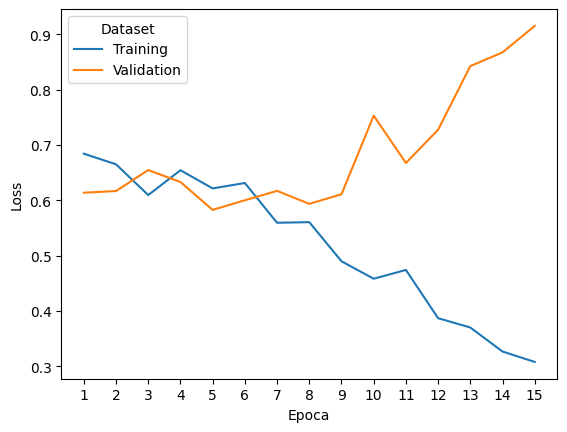

In [87]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{model_name}.pdf', dpi=300, bbox_inches='tight')
#plt.show()

In [93]:
output_predictions = trainer.predict(tokenized_val)

In [91]:
type(tokenized_val['labels'])

list

In [96]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [101]:
y_val = tokenized_val["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.59      0.67       279
           1       0.67      0.84      0.74       273

    accuracy                           0.71       552
   macro avg       0.73      0.71      0.71       552
weighted avg       0.73      0.71      0.71       552



AttributeError: ignored

In [102]:
with open(f"class_report_{model_name}.html", "w") as file:
    file.write(report)

In [98]:
import matplotlib.pyplot as plt

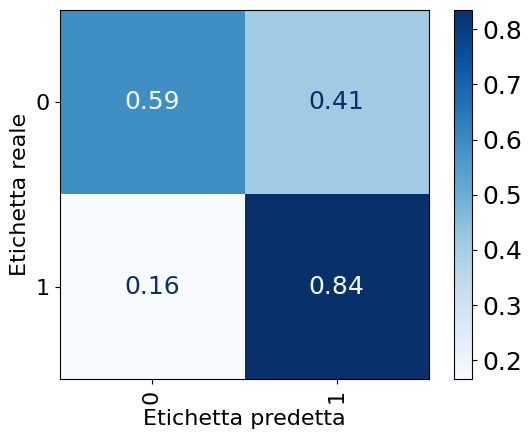

In [99]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, xticks_rotation='vertical', cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{model_name}.pdf', dpi=300, bbox_inches='tight')
plt.show()